In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
from tqdm import tqdm
torch.manual_seed(1)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [3]:
torch.cuda.empty_cache() 

# Create Train and Validation

In [4]:
X = []
Y = []
for p in tqdm(np.arange(0, 50), total = 50):
    X_p = torch.load('data_processed/1face_X_part' + str(p) + '.pt', map_location = device)
    Y_p = torch.load('data_processed/1face_Y_part' + str(p) + '.pt', map_location = device)
    X = X + X_p
    Y = Y + Y_p

100%|██████████| 50/50 [01:31<00:00,  1.97s/it]


In [5]:
len(X)

104343

In [6]:
len(Y)

104343

In [7]:
X = torch.stack(X)

In [8]:
X.shape

torch.Size([104343, 30, 512])

In [9]:
torch.save(X, './data_tomodel/X.pt')
torch.save(Y, './data_tomodel/Y.pt')

FileNotFoundError: [Errno 2] No such file or directory: './data_tomodel/X.pt'

In [9]:
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(X[0:104300], torch.from_numpy(np.array(Y[0:104300])))
train_data, val_data = torch.utils.data.random_split(dataset, [100000, 4300])
train_batch_size = 2000
val_batch_size = 100
train_loader = DataLoader(train_data, shuffle=True, batch_size=train_batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=val_batch_size)

# Create Model

In [51]:
import torch.nn as nn

class DFDCNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super(DFDCNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.75)
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.elu = nn.ELU()
        self.fc1 = nn.Linear(hidden_dim, 32)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(32, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.float()
        
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
#         out = self.batchnorm(out)
        out = self.fc1(out)
        out = self.elu(out)
#         out = self.fc2(out)
#         out = self.elu(out)
#         out = self.fc3(out)
#         out = self.elu(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [52]:
input_size = 512
output_size = 1
hidden_dim = 128
n_layers = 5

model = DFDCNet(input_size, output_size, hidden_dim, n_layers)
model.to(device)
train_criterion = nn.BCELoss()
val_criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

DFDCNet(
  (lstm): LSTM(512, 64, num_layers=5, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.75, inplace=False)
  (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [15]:
# scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, verbose=True)


In [ ]:
epochs = 10000
counter = 0
print_every = 1000
clip = .5
valid_loss_min = np.Inf
val_loss = torch.tensor(np.Inf)
model.train()
for i in range(epochs):
    h = model.init_hidden(train_batch_size)
    
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = train_criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        if counter%print_every == 0:
            val_h = model.init_hidden(val_batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = val_criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './model_1face.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)
    scheduler.step(val_loss.item())


Epoch: 10/10000... Step: 1000... Loss: 0.531787... Val Loss: 0.431874
Validation loss decreased (inf --> 0.431874).  Saving model ...
Epoch: 20/10000... Step: 2000... Loss: 0.472329... Val Loss: 0.431393
Validation loss decreased (0.431874 --> 0.431393).  Saving model ...
Epoch: 30/10000... Step: 3000... Loss: 0.449641... Val Loss: 0.431291
Validation loss decreased (0.431393 --> 0.431291).  Saving model ...
Epoch: 40/10000... Step: 4000... Loss: 0.437786... Val Loss: 0.430938
Validation loss decreased (0.431291 --> 0.430938).  Saving model ...
Epoch: 50/10000... Step: 5000... Loss: 0.443349... Val Loss: 0.431201
Epoch: 60/10000... Step: 6000... Loss: 0.466028... Val Loss: 0.430974
Epoch: 70/10000... Step: 7000... Loss: 0.462511... Val Loss: 0.430990
Epoch: 80/10000... Step: 8000... Loss: 0.465358... Val Loss: 0.431100
Epoch: 90/10000... Step: 9000... Loss: 0.467207... Val Loss: 0.431350
Epoch: 100/10000... Step: 10000... Loss: 0.455970... Val Loss: 0.431349
Epoch: 110/10000... Step: 1

# Reference
* https://github.com/gabrielloye/LSTM_Sentiment-Analysis/blob/master/main.ipynb

# Implemented history code to show train_loss and dev_loss (val_loss)
Testing original with history = history
adding all previous fc with (64, 32) and (32,16) all activated with ELU
0.9 dropout  << getting aggressive with dropout (looked like we overfitted on the model above. train_loss kept going down while val_loss hovered at .40)
0.0001 LR

In [10]:
import torch.nn as nn

class DFDCNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.9):
        super(DFDCNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.9)
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.elu = nn.ELU()
        self.fc1 = nn.Linear(hidden_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.float()
        
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
#         out = self.batchnorm(out)
        out = self.fc1(out)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        out = self.elu(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [11]:
input_size = 512
output_size = 1
hidden_dim = 128
n_layers = 5

model = DFDCNet(input_size, output_size, hidden_dim, n_layers)
model.to(device)
train_criterion = nn.BCELoss()
val_criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
print(model)

DFDCNet(
  (lstm): LSTM(512, 128, num_layers=5, batch_first=True, dropout=0.9)
  (dropout): Dropout(p=0.9, inplace=False)
  (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (elu): ELU(alpha=1.0)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [12]:
# scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=500, verbose=True)


In [13]:
epochs = 10000
counter = 0
print_every = 1000
clip = .5
valid_loss_min = np.Inf
val_loss = torch.tensor(np.Inf)
model.train()
history = pd.DataFrame()
for i in range(epochs):
    h = model.init_hidden(train_batch_size)
    
    for inputs, labels in train_loader:
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = train_criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        
        if counter%print_every == 0:
            val_h = model.init_hidden(val_batch_size)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = val_criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            history.loc[i + 1, 'train_loss'] = loss.data.cpu().numpy()
            history.loc[i + 1, 'dev_loss'] = val_loss.cpu().detach().numpy()
            
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './model_1face.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)
    scheduler.step(val_loss.item())


Epoch: 20/10000... Step: 1000... Loss: 0.447421... Val Loss: 0.447476
Validation loss decreased (inf --> 0.447476).  Saving model ...
Epoch: 40/10000... Step: 2000... Loss: 0.436513... Val Loss: 0.434345
Validation loss decreased (0.447476 --> 0.434345).  Saving model ...
Epoch: 60/10000... Step: 3000... Loss: 0.435026... Val Loss: 0.427582
Validation loss decreased (0.434345 --> 0.427582).  Saving model ...
Epoch: 80/10000... Step: 4000... Loss: 0.430853... Val Loss: 0.424114
Validation loss decreased (0.427582 --> 0.424114).  Saving model ...
Epoch: 100/10000... Step: 5000... Loss: 0.433941... Val Loss: 0.423616
Validation loss decreased (0.424114 --> 0.423616).  Saving model ...
Epoch: 120/10000... Step: 6000... Loss: 0.439497... Val Loss: 0.417461
Validation loss decreased (0.423616 --> 0.417461).  Saving model ...
Epoch: 140/10000... Step: 7000... Loss: 0.419833... Val Loss: 0.417426
Validation loss decreased (0.417461 --> 0.417426).  Saving model ...
Epoch: 160/10000... Step: 800

KeyboardInterrupt: 

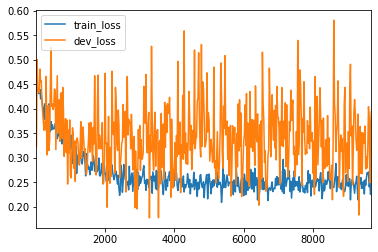

In [15]:
display(history.plot())